In [ ]:
# normalizing data through a sigmoid function
# seems to work quite well as an embedder

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Specify the columns you want to read
columns_to_read = ['heatmapsId', 'playerId', 'teamId', 'season', 'passes-start-heatmap']

# Initialize an empty list to store data from each file
all_data = []

# Loop through files and read data
for k in range(1, 25):  # Loop through files 1 to 24
    file_path = f'_normalized-heatmaps/normalized-heatmaps-chunk-{k}.csv'
    data_chunk = pd.read_csv(file_path, usecols=columns_to_read)
    all_data.append(data_chunk)

# Concatenate all the data into a single DataFrame
data = pd.concat(all_data, ignore_index=True)

# Apply sigmoid to the heatmap values
def sigmoid_heatmap(heatmap_str):
    # Convert the heatmap string to a numpy array
    heatmap = np.array(eval(heatmap_str))  # Assuming the heatmap is stored as a string of lists

    # Apply sigmoid
    sigmoid_heatmap = 1 / (1 + np.exp(-heatmap))  # Sigmoid function
    
    return sigmoid_heatmap.tolist()  # Convert back to list

# Apply sigmoid transformation and save as JSON strings
data['passes-start-heatmap'] = data['passes-start-heatmap'].apply(
    lambda x: json.dumps(sigmoid_heatmap(x))
)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% train
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save to CSV
train_data.to_csv("_Data-split/passes-start-train.csv", index=False)
val_data.to_csv("_Data-split/passes-start-validation.csv", index=False)
test_data.to_csv("_Data-split/passes-start-test.csv", index=False)

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt

class HeatmapCSVLoader(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.heatmaps = self.data["passes-start-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        return len(self.heatmaps)
    
    def __getitem__(self, idx):
        # Parse heatmap JSON string
        heatmap = json.loads(self.heatmaps.iloc[idx])
        heatmap_tensor = torch.tensor(heatmap, dtype=torch.float32)  # Convert to tensor
        
        # Add channel dimension for PyTorch (batch, channel, height, width)
        heatmap_tensor = heatmap_tensor.unsqueeze(0)
        
        # Return heatmap tensor and its metadata
        return heatmap_tensor, self.ids.iloc[idx], self.playerIds.iloc[idx], self.teamIds.iloc[idx], self.seasons.iloc[idx]    

In [1]:
# Use for pass and carries datasets, files with 2 heatmaps (start-end)

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt

class HeatmapCSVLoader(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.heatmaps_start = self.data["passes-start-heatmap"]
        self.heatmaps_end = self.data["passes-end-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        # Return the number of rows in the dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # Parse heatmaps JSON string
        heatmap_start = json.loads(self.heatmaps_start.iloc[idx])
        heatmap_start_tensor = torch.tensor(heatmap_start, dtype=torch.float32)  # Convert to tensor
        heatmap_end = json.loads(self.heatmaps_end.iloc[idx])
        heatmap_end_tensor = torch.tensor(heatmap_end, dtype=torch.float32)  # Convert to tensor
        
        # Add channel dimension for PyTorch (batch, channel, height, width)
        heatmap_start_tensor = heatmap_start_tensor.unsqueeze(0)
        heatmap_end_tensor = heatmap_end_tensor.unsqueeze(0)
        
        # Return heatmap tensor and its metadata
        return (
            heatmap_start_tensor,
            heatmap_end_tensor,
            self.ids.iloc[idx],
            self.playerIds.iloc[idx],
            self.teamIds.iloc[idx],
            self.seasons.iloc[idx]
        )

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.4.1+cu121
CUDA available: True


In [3]:
# Load datasets 
train_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-train.csv")
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-validation.csv")
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [4]:
# for passes and carries
# Filter test set to use only players with multiple heatmaps in a team/season for the retrieval task
from collections import defaultdict

# Load test dataset
test_data = pd.read_csv('/kaggle/input/pass-dataset/pass-test.csv')

# Group by playerId, teamId, and season and count rows in each group
grouped = test_data.groupby(["playerId", "teamId", "season"]).size()

# Filter combinations with more than one heatmap
valid_combinations = grouped[grouped > 1].index  # Get the indices of valid groups

# Create filtered test instances
filtered_test_instances = defaultdict(list)
for _, row in test_data.iterrows():
    key = (row["playerId"], row["teamId"], row["season"])
    if key in valid_combinations:
        # Add heatmap and heatmapsId to corresponding key
        heatmap_start = json.loads(row["passes-start-heatmap"])
        heatmap_end = json.loads(row["passes-end-heatmap"])
        heatmaps_id = row["heatmapsId"]
        filtered_test_instances[key].append((heatmaps_id, heatmap_start, heatmap_end))

# Convert to a list of tuples for later use
filtered_test_instances = [
    (playerId, teamId, season, heatmaps)
    for (playerId, teamId, season), heatmaps in filtered_test_instances.items()
]

In [ ]:
# Filter test set to use only players with multiple heatmaps in a team/season for the retrieval task
from collections import defaultdict

# Load test dataset
test_data = pd.read_csv('/kaggle/input/sigmod-1chunk/1passes-start-test.csv')

# Group by playerId, teamId, and season and count rows in each group
grouped = test_data.groupby(["playerId", "teamId", "season"]).size()

# Filter combinations with more than one heatmap
valid_combinations = grouped[grouped > 1].index  # Get the indices of valid groups

# Create filtered test instances
filtered_test_instances = defaultdict(list)
for _, row in test_data.iterrows():
    key = (row["playerId"], row["teamId"], row["season"])
    if key in valid_combinations:
        # Add heatmap and heatmapsId to corresponding key
        heatmap = json.loads(row["passes-start-heatmap"])
        heatmaps_id = row["heatmapsId"]
        filtered_test_instances[key].append((heatmaps_id, heatmap))

# Convert to a list of tuples for later use
filtered_test_instances = [
    (playerId, teamId, season, heatmaps)
    for (playerId, teamId, season), heatmaps in filtered_test_instances.items()
]

In [5]:
len(filtered_test_instances)

2148

In [6]:
filtered_test_instances[0]

(136057.0,
 195,
 '2022-2023',
 [('136057.0-195-2022-2023-3',
   [[0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.500027148559401,
     0.5008990358465949,
     0.5109507591302733,
     0.5489555506310991,
     0.5811049600682238,
     0.5597513607719062],
    [0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5001125038187515,
     0.5037255459197036,
     0.5452630261080164,
     0.6929818056118515,
     0.7951705780368129,
     0.7301129757238916],
    [0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5,
     0.5001853849001505,
     0.5061387965555987,
     0.5742367776239177,
     0.7927326712698736,
     0.9033535837035208,
  

In [ ]:
# CPU Embeddings
# Create embeddings for test instances, to compute MMR and top-k metrics
latent_vectors = {}
for playerId, teamId, season, heatmaps in filtered_test_instances:
    vectors_with_ids = []
    for heatmaps_id, heatmap in heatmaps:
        # Convert heatmap to tensor and move to the device
        hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        bottleneck, _ = autoencoder.encoder(hm_tensor)  # Get the bottleneck representation, ignore the indices_list
        vector = bottleneck.detach().cpu().numpy()  # Detach and convert to NumPy array
        # Append tuple of heatmapsId and latent vector
        vectors_with_ids.append((heatmaps_id, vector))
    latent_vectors[(playerId, teamId, season)] = vectors_with_ids

In [ ]:
num_keys = len(latent_vectors)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors = sum(len(vectors) for vectors in latent_vectors.values())
print(f"Total number of latent vectors: {total_latent_vectors}")

In [ ]:
# Create GPU-based latent_vectors_torch embeddings for similarity computation
latent_vectors_torch = {}
for playerId, teamId, season, heatmaps in filtered_test_instances[:100]:
    vectors_with_ids = []
    for heatmaps_id, heatmap in heatmaps:
        # Convert heatmap to a PyTorch tensor and move it to the GPU
        hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        bottleneck, _ = autoencoder.encoder(hm_tensor)  # Get the bottleneck representation
        # Store the tensor directly without detaching or moving it to CPU
        vectors_with_ids.append((heatmaps_id, bottleneck))
    latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids

num_keys = len(latent_vectors_torch)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
print(f"Total number of latent vectors: {total_latent_vectors_torch}")

In [ ]:
num_keys = len(latent_vectors_torch)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
print(f"Total number of latent vectors: {total_latent_vectors_torch}")

In [ ]:
# Use this to leverage GPU
import torch
import numpy as np

results = []
k_values = [1, 3, 5, 10]  # List of k values

# Loop through each query vector
for (playerId, teamId, season), vectors_with_ids in latent_vectors_torch.items():
    for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
        similarities = []  # Store similarities for the current query vector

        # Compare with all other vectors in the dataset
        for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors_torch.items():
            for other_heatmaps_id, other_vector in other_vectors_with_ids:
                if other_heatmaps_id == heatmaps_id:  # Skip self-comparison
                    continue
                
                # Compute cosine similarity
                sim = torch.nn.functional.cosine_similarity(
                    query_vector.flatten().unsqueeze(0),
                    other_vector.flatten().unsqueeze(0)
                ).item()
                similarities.append((sim, (other_playerId, other_teamId, other_season)))

        # Sort by similarity in descending order
        similarities.sort(reverse=True, key=lambda x: x[0])

        # Evaluate rankings for each k
        ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}

        # Calculate top-k accuracy for each k value
        top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}

        # Calculate MRR
        mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0  # MRR for k=10

        # Store the result for the current query
        results.append({
            'query': (playerId, teamId, season),
            'mrr': mrr,
            'top_k_values': top_k_values,  # Dictionary with top-k accuracy for each k
        })

# Calculate averages for each k
avg_mrr = np.mean([result['mrr'] for result in results])
avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

# Output results
print(f"Average MRR: {avg_mrr:.4f}")
for k, avg_top_k in avg_top_k_values.items():
    print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

results = []
k_values = [1, 3, 5, 10]  # List of k values

for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
    # Loop over each query vector for the current (playerId, teamId, season)
    for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
        # Compute similarity between the query vector and all other vectors
        similarities = []
        for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
            for other_heatmaps_id, other_vector in other_vectors_with_ids:
                # Skip comparison if the heatmap is the same (i.e., avoid comparing the vector with itself)
                if other_heatmaps_id == heatmaps_id:
                    continue
                # Compute cosine similarity between query vector and other vector
                sim = cosine_similarity(query_vector.reshape(1, -1), other_vector.reshape(1, -1))[0][0]
                similarities.append((sim, (other_playerId, other_teamId, other_season)))
        
        # Sort by similarity in descending order
        similarities.sort(reverse=True, key=lambda x: x[0])

        # Evaluate rankings for each k
        ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}
        
        # Calculate top-k accuracy for each k value
        top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}

        # Calculate MRR
        mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0  # MRR for k=10 (you can adjust this as needed)

        results.append({
            'query': (playerId, teamId, season),
            'mrr': mrr,
            'top_k_values': top_k_values,  # Dictionary with top-k accuracy for each k
        })

# Calculate averages for each k
avg_mrr = np.mean([result['mrr'] for result in results])
avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

print(f"Average MRR: {avg_mrr:.4f}")
for k, avg_top_k in avg_top_k_values.items():
    print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

# In the comparison with Matteo's results, from top-3 upwards I should expect higher scores since in my method I have more than 1 correct instance retrievable for some players (the ones with more than 2 heatmaps)

In [ ]:
import matplotlib.pyplot as plt

test_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-pass-heatmaps/passes-start-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Get a batch of images
autoencoder.eval()
images, ids, playerIds, teamIds, seasons = next(iter(test_loader))
images = images.to(device)  # Move images to the selected device

# Reconstruct images
with torch.no_grad():
    reconstructed = autoencoder(images)

# Plot original and reconstructed images (limit to 5 for better visualization)
num_examples = min(len(images), 5)  # Display up to 5 examples
fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
for i in range(num_examples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    if isinstance(ids, (list, tuple)):
        axes[0, i].set_title(f"Original ({ids[i]})")
    else:
        axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Encoder class for grid search

class Encoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Encoder, self).__init__()
        
        # Conv Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Compute flattened size after convolutions and pooling
        self.flattened_size = 256 * 4 * 2  # Computed from input size [1, 35, 23]
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, bottleneck_size),
            nn.Dropout(p=dropout_rate)
        )
    
    def forward(self, x):
        # Conv Block 1
        x = self.conv_block1(x)
        x, indices1 = self.pool1(x)
        
        # Conv Block 2
        x = self.conv_block2(x)
        x, indices2 = self.pool2(x)
        
        # Conv Block 3
        x = self.conv_block3(x)
        x, indices3 = self.pool3(x)

        # Flatten and bottleneck
        x = self.flatten(x)
        bottleneck = self.dense(x)
        
        return bottleneck, [indices1, indices2, indices3]


In [8]:
# Decoder class for grid search

class Decoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Decoder, self).__init__()

        self.dense = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 4 * 2),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 2))

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid()
        )

    def forward(self, x, indices_list, output_sizes):
        # Dense layer and unflatten
        x = self.dense(x)
        x = self.unflatten(x)

        # Unpooling and deconvolution
        x = self.unpool3(x, indices_list[2], output_size=output_sizes[2])
        x = self.deconv_block3(x)

        x = self.unpool2(x, indices_list[1], output_size=output_sizes[1])
        x = self.deconv_block2(x)

        x = self.unpool1(x, indices_list[0], output_size=output_sizes[0])
        x = self.deconv_block1(x)

        return x

In [9]:
# Autoencoder class for grid search

class Autoencoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, bottleneck_size, dropout_rate)
        self.decoder = Decoder(input_channels, bottleneck_size, dropout_rate)

    def forward(self, x):
        # Encoder
        bottleneck, indices_list = self.encoder(x)

        # Verify output_sizes match shapes before pooling
        output_sizes = [
            torch.Size([x.size(0), 1, 35, 23]),    # Before Pool1
            torch.Size([x.size(0), 64, 17, 11]),  # Before Pool2
            torch.Size([x.size(0), 128, 8, 5])    # Before Pool3
        ]

        # Decoder
        reconstructed = self.decoder(bottleneck, indices_list, output_sizes)
        return reconstructed

In [10]:
# Define EarlyStopping class

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Hyperparameter grid

learning_rates = [1e-4]
bottleneck_sizes = [64]
optimizers = ['Adam']
loss_functions = ['MSELoss']
batch_sizes = [128]
weight_decays = [0]
dropout_rates = [0.0]

In [11]:
# testing with one parameter per type

learning_rates = [1e-03,1e-04]
bottleneck_sizes = [16,32]
optimizers = ['Adam']
loss_functions = ['MSELoss']
batch_sizes = [128]
weight_decays = [0,0.001]
dropout_rates = [0.0,0.2]

In [12]:
# Function to get optimizer

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [13]:
# Function to get loss function

def get_loss_function(loss_name):
    if loss_name == 'MSELoss':
        return nn.MSELoss()
    elif loss_name == 'SmoothL1Loss':
        return nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

In [14]:
results = []

# Function to add a result
def save_result(hyperparams, metrics):
    result = {
        "hyperparameters": hyperparams,
        "metrics": metrics,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    results.append(result)

In [ ]:
train_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-train.csv")
val_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-validation.csv")

In [15]:
# Create GPU-based latent_vectors_torch embeddings for similarity computation

def create_test_embeddings(embedder,filtered_test_instances):
    latent_vectors_torch = {}
    for playerId, teamId, season, heatmaps in filtered_test_instances:
        vectors_with_ids = []
        for heatmaps_id, heatmap in heatmaps:
            # Convert heatmap to a PyTorch tensor and move it to the GPU
            hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            bottleneck, _ = embedder(hm_tensor)  # Get the bottleneck representation
            # Store the tensor directly without detaching or moving it to CPU
            vectors_with_ids.append((heatmaps_id, bottleneck))
        latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids
    
    num_keys = len(latent_vectors_torch)
    print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
    total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
    print(f"Total number of latent vectors: {total_latent_vectors_torch}")
    return latent_vectors_torch

In [23]:
# For passes and carries
# Create GPU-based latent_vectors_torch embeddings for similarity computation

def create_test_embeddings(embedder,filtered_test_instances):
    latent_vectors_torch = {}
    for playerId, teamId, season, heatmaps in filtered_test_instances:
        vectors_with_ids = []
        for heatmaps_id, heatmap_start, heatmap_end in heatmaps:
            # Convert heatmap to a PyTorch tensor and move it to the GPU
            hm_start_tensor = torch.tensor(heatmap_start, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            hm_end_tensor = torch.tensor(heatmap_end, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            hm_tensor = torch.cat((hm_start_tensor,hm_end_tensor),dim=1)
            bottleneck, _ = embedder(hm_tensor)  # Get the bottleneck representation
            # Store the tensor directly without detaching or moving it to CPU
            vectors_with_ids.append((heatmaps_id, bottleneck))
        latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids
    
    num_keys = len(latent_vectors_torch)
    print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
    total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
    print(f"Total number of latent vectors: {total_latent_vectors_torch}")
    return latent_vectors_torch

In [16]:
# Function to compute cosine similarity (GPU/CPU)

from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(latent_vectors, k_values, use_gpu):
    """
    Computes MRR and Top-k accuracy metrics for a set of latent vectors.

    Parameters:
        latent_vectors (dict): Dictionary of latent vectors.
        k_values (list): List of k values for top-k accuracy.
        use_gpu (bool): Whether to use GPU for computations.

    Returns:
        avg_mrr (float): Average MRR.
        avg_top_k_values (dict): Average Top-k accuracy for each k.
    """
    results = []

    for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
        for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
            similarities = []

            for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
                for other_heatmaps_id, other_vector in other_vectors_with_ids:
                    if other_heatmaps_id == heatmaps_id:
                        continue

                    if use_gpu:
                        query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        sim = torch.nn.functional.cosine_similarity(query_tensor, other_tensor).item()
                    else:
                        sim = cosine_similarity(query_vector.reshape(1, -1), other_vector.reshape(1, -1))[0][0]

                    similarities.append((sim, (other_playerId, other_teamId, other_season)))

            similarities.sort(reverse=True, key=lambda x: x[0])
            ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}
            top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}
            mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0

            results.append({
                'query': (playerId, teamId, season),
                'mrr': mrr,
                'top_k_values': top_k_values,
            })

    avg_mrr = np.mean([result['mrr'] for result in results])
    avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

    return avg_mrr, avg_top_k_values

In [ ]:
# Function to compute similarity with Manhattan Distance (GPU/CPU)

def compute_similarity_with_manhattan(latent_vectors, k_values, use_gpu):
    """
    Computes similarity among vector embeddings using Manhattan distance.

    Args:
        latent_vectors (dict): Dictionary of latent vectors.
        k_values (list): List of k values for top-k accuracy.
        use_gpu (bool): Whether to use GPU for computations.

    Returns:
        avg_mrr (float): Average MRR.
        avg_top_k_values (dict): Average Top-k accuracy for each k.
    """
    results = []

    for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
        for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
            distances = []

            for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
                for other_heatmaps_id, other_vector in other_vectors_with_ids:
                    if other_heatmaps_id == heatmaps_id:
                        continue

                    if use_gpu:
                        query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        dist = torch.sum(torch.abs(query_tensor - other_tensor)).item()
                    else:
                        dist = np.sum(np.abs(query_vector - other_vector))

                    distances.append((dist, (other_playerId, other_teamId, other_season)))

            # Sort by ascending distance (lower distance is more similar)
            distances.sort(key=lambda x: x[0])
            ranks = {k: [key == (playerId, teamId, season) for _, key in distances[:k]] for k in k_values}
            top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}
            mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0

            results.append({
                'query': (playerId, teamId, season),
                'mrr': mrr,
                'top_k_values': top_k_values,
            })

    avg_mrr = np.mean([result['mrr'] for result in results])
    avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

    return avg_mrr, avg_top_k_values


In [ ]:
def compute_similarity_with_euclidean(latent_vectors, k_values, use_gpu):
    """
    Computes similarity among vector embeddings using Euclidean distance.

    Args:
        latent_vectors (dict): Dictionary of latent vectors.
        k_values (list): List of k values for top-k accuracy.
        use_gpu (bool): Whether to use GPU for computations.

    Returns:
        avg_mrr (float): Average MRR.
        avg_top_k_values (dict): Average Top-k accuracy for each k.
    """
    results = []

    for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
        for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
            distances = []

            for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
                for other_heatmaps_id, other_vector in other_vectors_with_ids:
                    if other_heatmaps_id == heatmaps_id:
                        continue

                    if use_gpu:
                        query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        dist = torch.sqrt(torch.sum((query_tensor - other_tensor) ** 2)).item()
                    else:
                        dist = np.sqrt(np.sum((query_vector - other_vector) ** 2))

                    distances.append((dist, (other_playerId, other_teamId, other_season)))

            # Sort by ascending distance (lower distance is more similar)
            distances.sort(key=lambda x: x[0])
            ranks = {k: [key == (playerId, teamId, season) for _, key in distances[:k]] for k in k_values}
            top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}
            mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0

            results.append({
                'query': (playerId, teamId, season),
                'mrr': mrr,
                'top_k_values': top_k_values,
            })

    avg_mrr = np.mean([result['mrr'] for result in results])
    avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

    return avg_mrr, avg_top_k_values

In [17]:
# Utility function to create a test subset
def create_test_subset(test_instances, size_fraction=0.10):
    subset_size = ceil(len(test_instances) * size_fraction)
    subset_indices = random.sample(range(len(test_instances)), subset_size)
    return [test_instances[i] for i in subset_indices]

In [18]:
# Function to compute and store metrics
def compute_and_store_metrics(autoencoder, test_subset, epoch, k_values, use_gpu, history):
    print(f"Creating embeddings at epoch {epoch} on a subset of size {len(test_subset)}...")
    latent_vectors_torch = create_test_embeddings(autoencoder.encoder, test_subset)

    print(f"Computing metrics at epoch {epoch}...")
    metrics_start_time = time.time()
    avg_mrr, avg_top_k_values = compute_similarity(latent_vectors_torch, k_values, use_gpu) # computing similarity with cosine similarity
    metrics_end_time = time.time()

    print(f"Metrics computation time (epoch {epoch}): {metrics_end_time - metrics_start_time:.2f} seconds")
    history["mrr"].append(avg_mrr)
    print(f"Average MRR: {avg_mrr:.4f}")
    
    for k, avg_top_k in avg_top_k_values.items():
        history["top_k_accuracies"][k].append(avg_top_k)
        print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.014943743063744417, Average Batch Validation Loss: 0.00507124494567203
Epoch [2/10], Average Batch Training Loss: 0.0026388566066372506, Average Batch Validation Loss: 0.0016409339082504933
Epoch [3/10], Average Batch Training Loss: 0.0012115916726207338, Average Batch Validation Loss: 0.0009433860631058148
Epoch [4/10], Average Batch Training Loss: 0.0008919471320673841, Average Batch Validation Loss: 0.00082577813033519
Epoch [5/10], Average Batch Training Loss: 0.0007805533783774984, Average Batch Validation Loss: 0.0007403283765597734
Epoch [6/10], Average Batch Training Loss: 0.0008718215884714514, Average Batch Validation Loss: 0.0007431970620624877
Epoch [7/10], Average Batch Training Loss: 0.0007074056200211872, Average Batch Validation Loss: 0.0006583438356756232
Epoch [

<ipython-input-16-4bc8d80f1a81>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
<ipython-input-16-4bc8d80f1a81>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()


Metrics computation time (epoch 10): 34.91 seconds
Average MRR: 0.1250
Average Top-1 Accuracy: 0.0654
Average Top-3 Accuracy: 0.1264
Average Top-5 Accuracy: 0.2092
Average Top-10 Accuracy: 0.3268
results.json updated


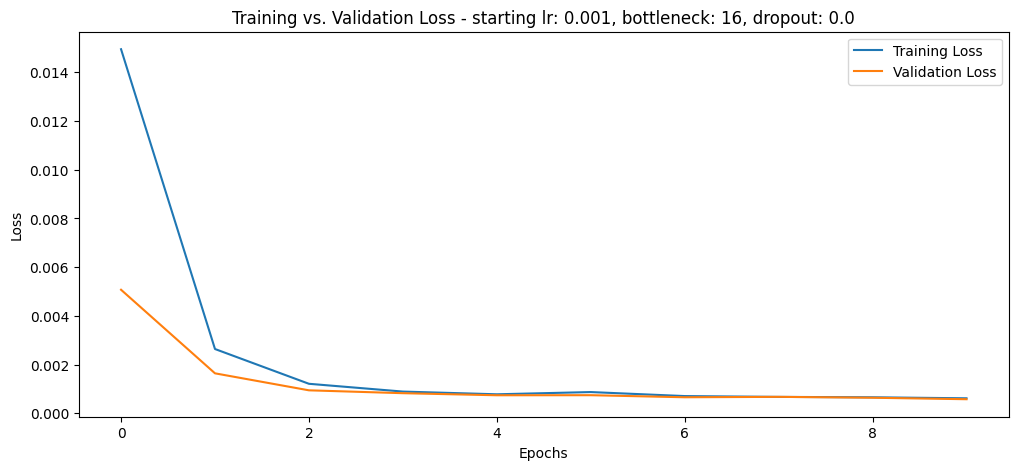

Model train time: 159.76 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.015891190176065877, Average Batch Validation Loss: 0.00453926976188086
Epoch [2/10], Average Batch Training Loss: 0.003158739359258748, Average Batch Validation Loss: 0.0017549128984683192
Epoch [3/10], Average Batch Training Loss: 0.001940268808216464, Average Batch Validation Loss: 0.001359318446581407
Epoch [4/10], Average Batch Training Loss: 0.0015122330962787482, Average Batch Validation Loss: 0.0011292444629361852
Epoch [5/10], Average Batch Training Loss: 0.0013900408123472452, Average Batch Validation Loss: 0.0012668124346722229
Epoch [6/10], Average Batch Training Loss: 0.0013363499253568388, Average Batch Validation Loss: 0.0009904434642521664
Epoch [7/10], Average Batch Training Loss: 0.0011847291393842039, Average Batch Validation Los

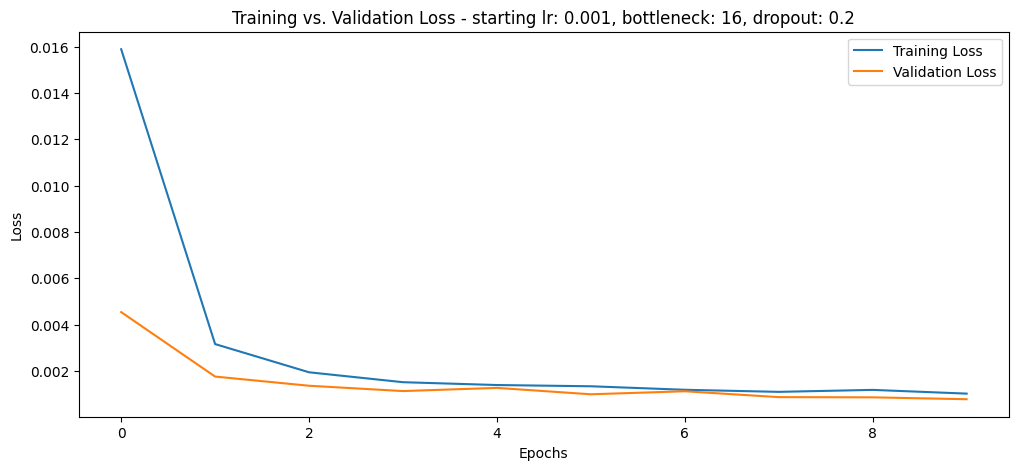

Model train time: 159.12 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.017558275966523148, Average Batch Validation Loss: 0.016930653876625002
Epoch [2/10], Average Batch Training Loss: 0.006057619586211743, Average Batch Validation Loss: 0.005287828284781426
Epoch [3/10], Average Batch Training Loss: 0.005470345536865544, Average Batch Validation Loss: 0.009783377187947433
Epoch [4/10], Average Batch Training Loss: 0.006345621790911118, Average Batch Validation Loss: 0.01341202442223827
Epoch [5/10], Average Batch Training Loss: 0.007462135868982303, Average Batch Validation Loss: 0.011219975592878958
Epoch [6/10], Average Batch Training Loss: 0.009815599257908135, Average Batch Validation Loss: 0.014241129660513252
Creating embeddings at epoch 7 on a subset of size 215...
Number of unique (playerId, teamId, sea

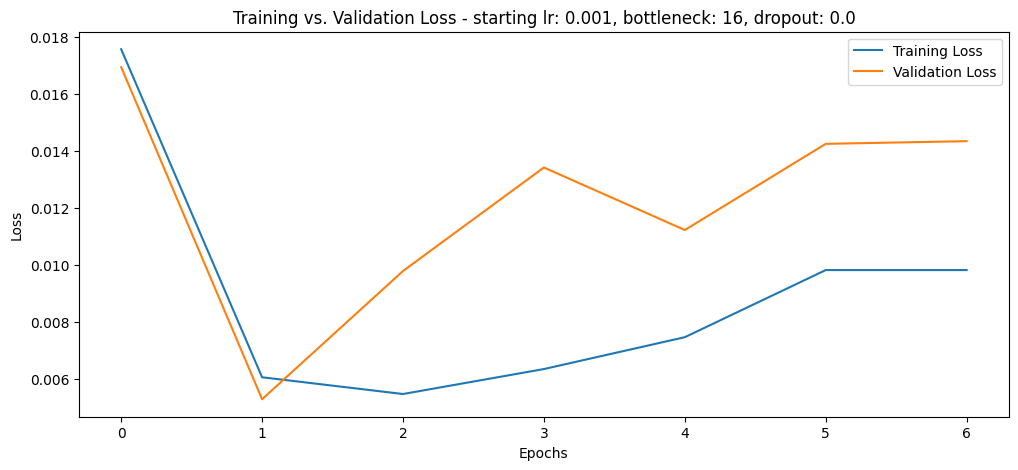

Model train time: 157.37 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.017776490195835236, Average Batch Validation Loss: 0.011352877734073749
Epoch [2/10], Average Batch Training Loss: 0.007002494358223119, Average Batch Validation Loss: 0.008663179694364469
Epoch [3/10], Average Batch Training Loss: 0.006563474525244152, Average Batch Validation Loss: 0.014893999971294154
Epoch [4/10], Average Batch Training Loss: 0.006051940109236814, Average Batch Validation Loss: 0.005691322651303684
Epoch [5/10], Average Batch Training Loss: 0.007470734108114343, Average Batch Validation Loss: 0.008211834133059407
Epoch [6/10], Average Batch Training Loss: 0.00953021508583473, Average Batch Validation Loss: 0.01127551388926804
Epoch [7/10], Average Batch Training Loss: 0.010011165367095447, Average Batch Validation Loss: 0.

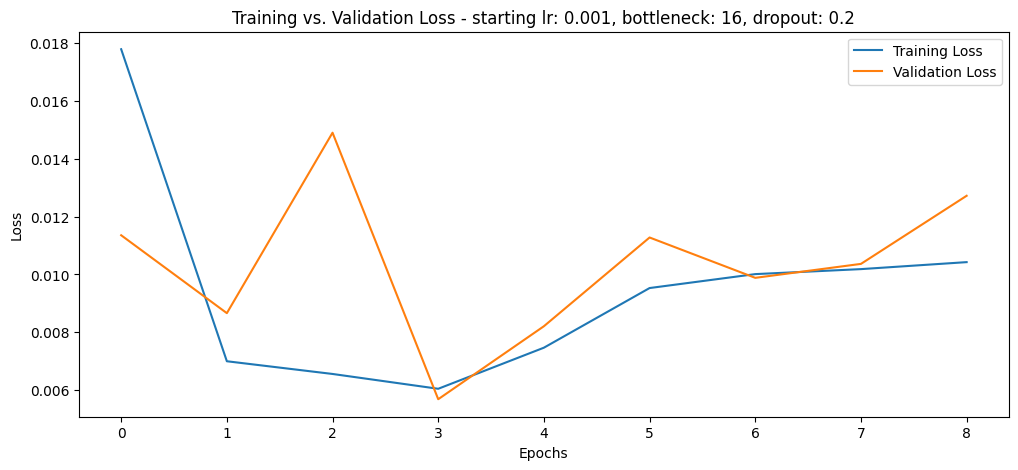

Model train time: 158.34 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.01581658309044169, Average Batch Validation Loss: 0.004593698886067917
Epoch [2/10], Average Batch Training Loss: 0.0027627363630427534, Average Batch Validation Loss: 0.0015983616996284886
Epoch [3/10], Average Batch Training Loss: 0.0012274599404909538, Average Batch Validation Loss: 0.0009570998617467315
Epoch [4/10], Average Batch Training Loss: 0.0008185842987769719, Average Batch Validation Loss: 0.0007127298832832215
Epoch [5/10], Average Batch Training Loss: 0.0006936207245192234, Average Batch Validation Loss: 0.0006199589350823468
Epoch [6/10], Average Batch Training Loss: 0.0006322044177356062, Average Batch Validation Loss: 0.000571722817888561
Epoch [7/10], Average Batch Training Loss: 0.0005838238190004169, Average Batch Validation L

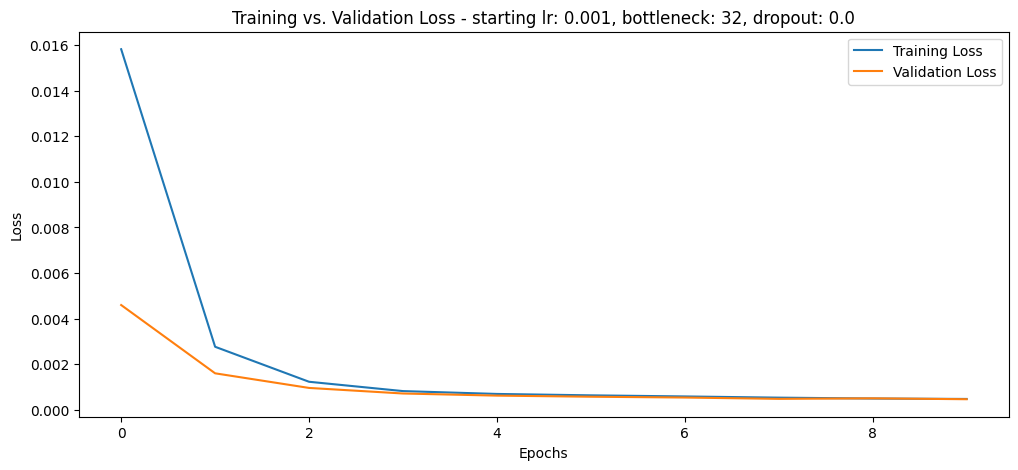

Model train time: 160.46 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.015393084643198718, Average Batch Validation Loss: 0.0047782590709781895
Epoch [2/10], Average Batch Training Loss: 0.0030534762554976203, Average Batch Validation Loss: 0.0015049193801435952
Epoch [3/10], Average Batch Training Loss: 0.0015232714287527977, Average Batch Validation Loss: 0.0010827805822676358
Epoch [4/10], Average Batch Training Loss: 0.0012626782372622913, Average Batch Validation Loss: 0.0009231485402172742
Epoch [5/10], Average Batch Training Loss: 0.0012876768878435523, Average Batch Validation Loss: 0.0010036582636530512
Epoch [6/10], Average Batch Training Loss: 0.0011201284022340707, Average Batch Validation Loss: 0.000839215091400547
Epoch [7/10], Average Batch Training Loss: 0.000986115708743385, Average Batch Validation 

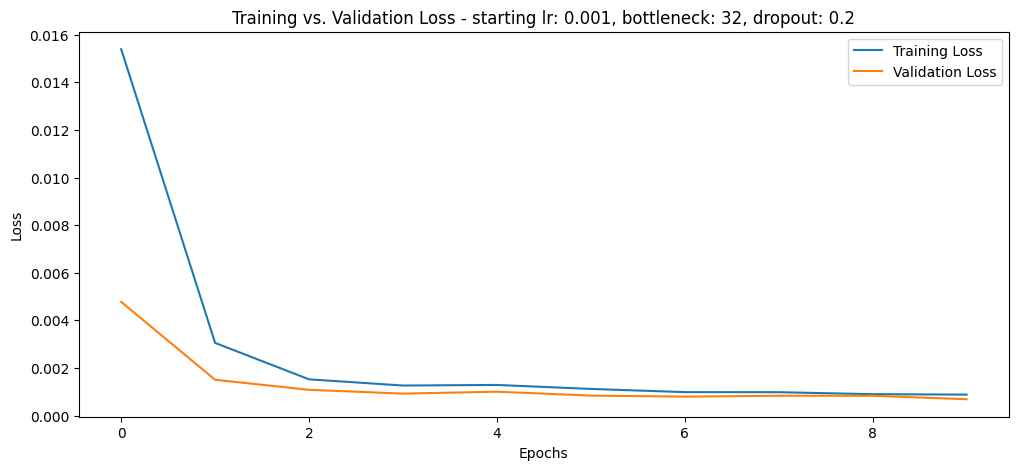

Model train time: 160.09 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.01867719507403225, Average Batch Validation Loss: 0.07052082450439533
Epoch [2/10], Average Batch Training Loss: 0.007858380666940654, Average Batch Validation Loss: 0.013044096118149658
Epoch [3/10], Average Batch Training Loss: 0.00765480946278204, Average Batch Validation Loss: 0.01975334227705995
Epoch [4/10], Average Batch Training Loss: 0.008695678200295789, Average Batch Validation Loss: 0.010463887507406374
Epoch [5/10], Average Batch Training Loss: 0.008893884952365459, Average Batch Validation Loss: 0.010021431790664791
Epoch [6/10], Average Batch Training Loss: 0.009126797846654693, Average Batch Validation Loss: 0.009601970315755656
Epoch [7/10], Average Batch Training Loss: 0.009183018579989743, Average Batch Validation Loss: 0.00

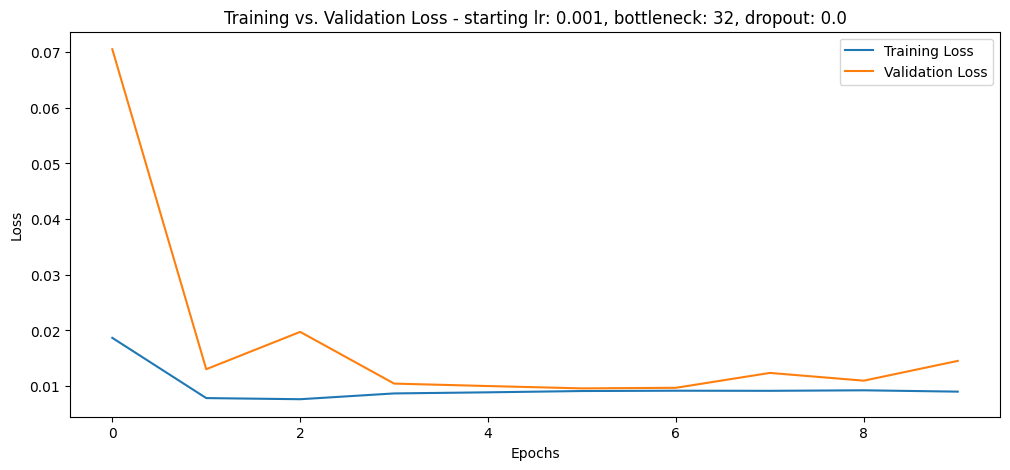

Model train time: 160.29 seconds
Training model with parameters: 
Learning Rate: 0.001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.01847688685678285, Average Batch Validation Loss: 0.01779013255921503
Epoch [2/10], Average Batch Training Loss: 0.00800254166112851, Average Batch Validation Loss: 0.008002294524339959
Epoch [3/10], Average Batch Training Loss: 0.008267911804875704, Average Batch Validation Loss: 0.012653472383196156
Epoch [4/10], Average Batch Training Loss: 0.008875330681722762, Average Batch Validation Loss: 0.010725543407412866
Epoch [5/10], Average Batch Training Loss: 0.009318044539809013, Average Batch Validation Loss: 0.01489007385680452
Epoch [6/10], Average Batch Training Loss: 0.009968615124756984, Average Batch Validation Loss: 0.018038246237362426
Creating embeddings at epoch 7 on a subset of size 215...
Number of unique (playerId, teamId, season

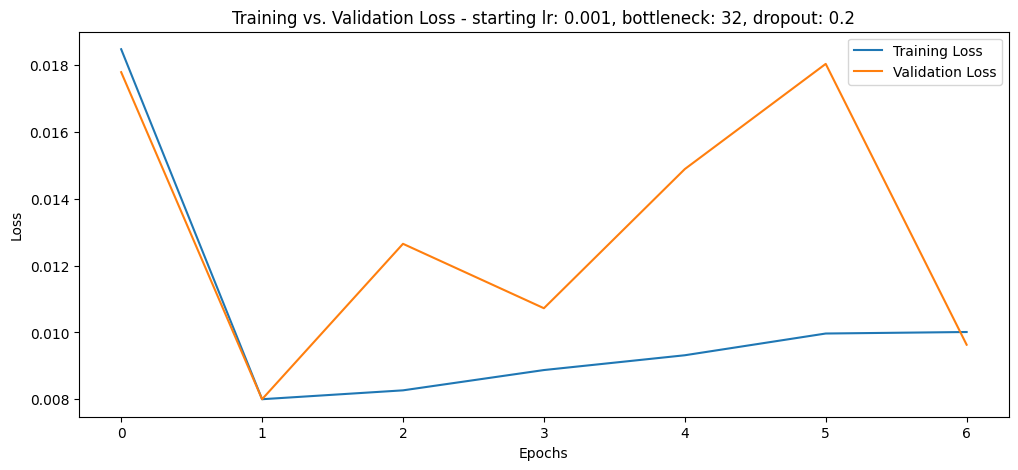

Model train time: 161.95 seconds
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.03352584974389139, Average Batch Validation Loss: 0.026267895591445267
Epoch [2/10], Average Batch Training Loss: 0.023251320880880173, Average Batch Validation Loss: 0.019965389324352146
Epoch [3/10], Average Batch Training Loss: 0.018286852363711425, Average Batch Validation Loss: 0.015923158125951888
Epoch [4/10], Average Batch Training Loss: 0.014428287511133104, Average Batch Validation Loss: 0.012851231067907065
Epoch [5/10], Average Batch Training Loss: 0.011293424810428056, Average Batch Validation Loss: 0.009520366826715568
Epoch [6/10], Average Batch Training Loss: 0.00886303186249122, Average Batch Validation Loss: 0.0074443231065136695
Epoch [7/10], Average Batch Training Loss: 0.0067515522046171, Average Batch Validation Loss: 0.0060

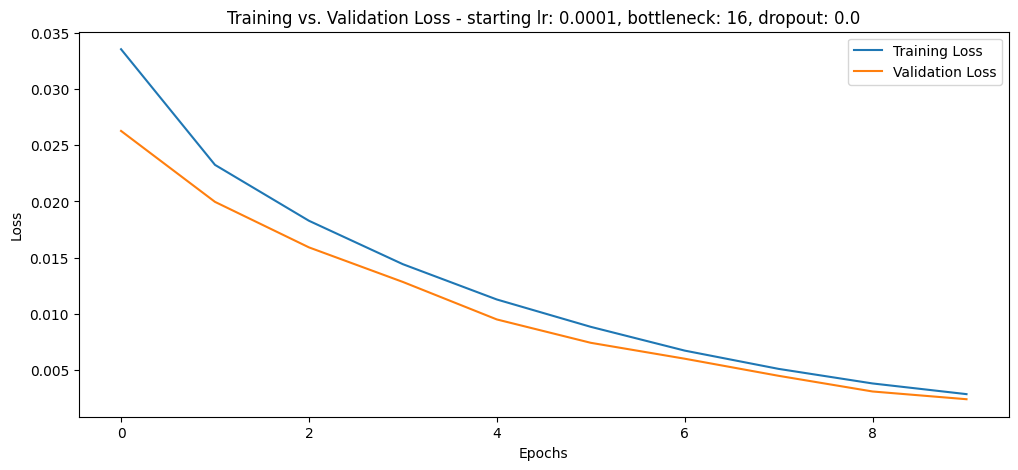

Model train time: 158.72 seconds
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.03531416529249087, Average Batch Validation Loss: 0.02872596731564651
Epoch [2/10], Average Batch Training Loss: 0.024007765958152658, Average Batch Validation Loss: 0.02299422244541347
Epoch [3/10], Average Batch Training Loss: 0.018842100228319208, Average Batch Validation Loss: 0.016391761410826197
Epoch [4/10], Average Batch Training Loss: 0.014844764594649739, Average Batch Validation Loss: 0.012699098244775086
Epoch [5/10], Average Batch Training Loss: 0.011834783271866307, Average Batch Validation Loss: 0.010324378959679355
Epoch [6/10], Average Batch Training Loss: 0.009195478505743064, Average Batch Validation Loss: 0.008792865928262472
Epoch [7/10], Average Batch Training Loss: 0.0072097318856675415, Average Batch Validation Loss: 0.005

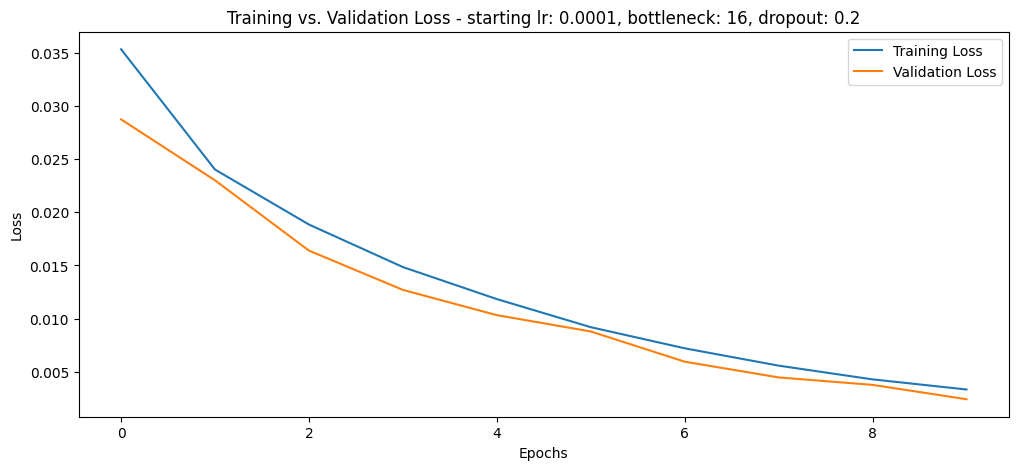

Model train time: 159.83 seconds
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.032885399472852836, Average Batch Validation Loss: 0.029111860777872305
Epoch [2/10], Average Batch Training Loss: 0.022632153700295685, Average Batch Validation Loss: 0.02211555092750738
Epoch [3/10], Average Batch Training Loss: 0.01857298055699439, Average Batch Validation Loss: 0.01705485147734483
Epoch [4/10], Average Batch Training Loss: 0.014777882096114204, Average Batch Validation Loss: 0.0134200537771297
Epoch [5/10], Average Batch Training Loss: 0.011952013428360938, Average Batch Validation Loss: 0.01693605664962282
Epoch [6/10], Average Batch Training Loss: 0.010110744265660786, Average Batch Validation Loss: 0.008791450973755369
Epoch [7/10], Average Batch Training Loss: 0.007827763071024625, Average Batch Validation Loss: 0.007

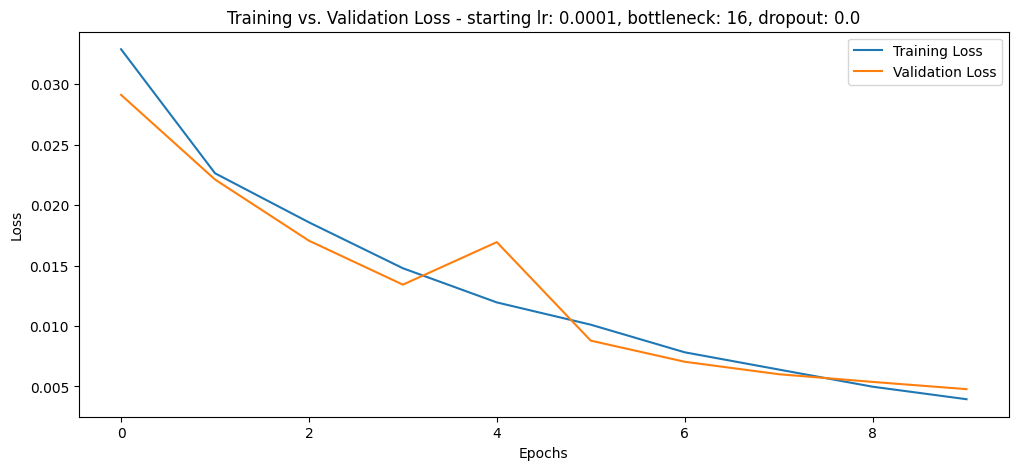

Model train time: 161.44 seconds
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 16, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0.001, Dropout Rate: 0.2
Epoch [1/10], Average Batch Training Loss: 0.0336953572799369, Average Batch Validation Loss: 0.028379405188995104
Epoch [2/10], Average Batch Training Loss: 0.023231181563983717, Average Batch Validation Loss: 0.022283359873108567
Epoch [3/10], Average Batch Training Loss: 0.01880072835024348, Average Batch Validation Loss: 0.017797206792359552
Epoch [4/10], Average Batch Training Loss: 0.015216147215541103, Average Batch Validation Loss: 0.014721519240022947
Epoch [5/10], Average Batch Training Loss: 0.012160830318088012, Average Batch Validation Loss: 0.011433576074584078
Epoch [6/10], Average Batch Training Loss: 0.010171389178209882, Average Batch Validation Loss: 0.009692536826090265
Epoch [7/10], Average Batch Training Loss: 0.008724579987913478, Average Batch Validation Loss: 0.

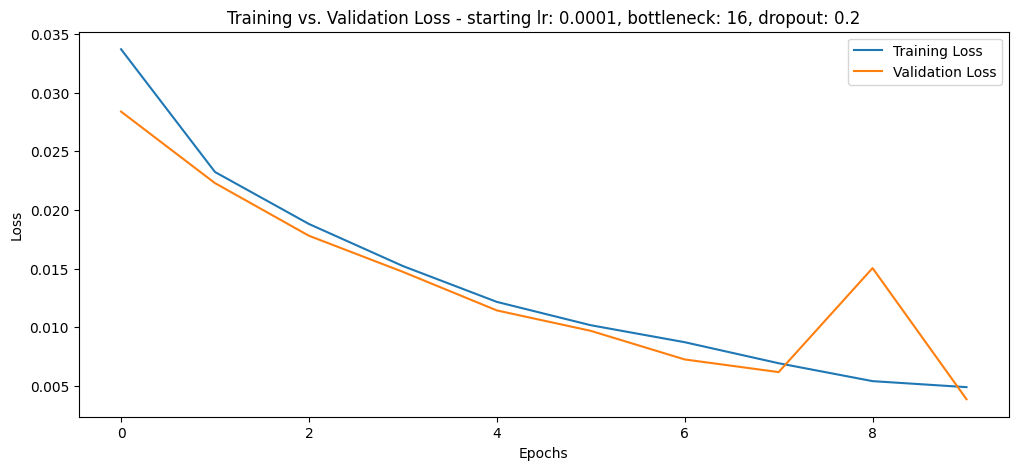

Model train time: 159.71 seconds
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.0
Epoch [1/10], Average Batch Training Loss: 0.03327337242841578, Average Batch Validation Loss: 0.026433831507650513


In [ ]:
# Constant learning rate!
# Training with grid search and evaluation on MSE and Retrieval Task only at the end
# Here the goal is to find the best hyperparameters to then use them to train the final (large) model

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
import random
from math import ceil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
k_values = [1, 3, 5, 10]  # List of k values
use_gpu = True

results = []
num_epochs = 10

start_time = time.time()
# Grid Search Loop
for lr, bottleneck, optimizer_name, loss_name, batch_size, weight_decay, dropout_rate in product(
    learning_rates, bottleneck_sizes, optimizers, loss_functions, batch_sizes, weight_decays, dropout_rates
):
    model_start_train_time = time.time()
    # Prepare DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    
    # Initialize model
    autoencoder = Autoencoder(input_channels=2, bottleneck_size=bottleneck, dropout_rate=dropout_rate).to(device)
    
    # Get optimizer and loss function
    optimizer = get_optimizer(optimizer_name, autoencoder.parameters(), lr, weight_decay)
    criterion = get_loss_function(loss_name)

    # Record initial hyperparameters
    hyperparams = {
        "learning_rate": lr, "bottleneck_size": bottleneck, "optimizer": optimizer_name,
        "loss_function": loss_name, "batch_size": batch_size, "weight_decay": weight_decay,
        "dropout_rate": dropout_rate
    }

    # History tracking
    history = {
        "train_loss": [], "val_loss": [], "learning_rate": [], "mrr": [],
        "top_k_accuracies": {k: [] for k in k_values}
    }

    # skipping creating latent vectors for training and validation data, since here I am just looking for the best hyperparameters
    # I may need to do this step when I'll train the final model and I will need only the training latent vectors, since the validation set will not exist (already found the best hyperparameters)
    # latent_vectors_train = {}  # Store latent vectors for training data

    # Train model
    early_stopping = EarlyStopping(patience=5)
    print(f"Training model with parameters: \nLearning Rate: {lr}, Bottleneck: {bottleneck}, Optimizer: {optimizer_name}, Loss Function: {loss_name},\n Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}")
    for epoch in range(num_epochs):
        autoencoder.train()
        train_loss = 0
        for batch in train_loader:
            images_start, images_end, ids, playerIds, teamIds, seasons = batch  # Unpack images and metadata
            images_start = images_start.to(device)
            images_end = images_end.to(device)

            #forward pass 
            input_tensor = torch.cat((images_start, images_end), dim=1)
            reconstructed = autoencoder(input_tensor)
            loss = criterion(reconstructed, input_tensor)  
        
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)
        
        # Validate model
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images_start, images_end, ids, playerIds, teamIds, seasons = batch # Unpack images and metadata
                images_start = images_start.to(device)
                images_end = images_end.to(device)
                input_tensor = torch.cat((images_start, images_end), dim=1)
                reconstructed = autoencoder(input_tensor)
                val_loss += criterion(reconstructed, input_tensor).item() 
        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Batch Training Loss: {train_loss}, Average Batch Validation Loss: {val_loss}")

    test_subset = create_test_subset(filtered_test_instances)
    compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)
    
    results.append({"hyperparams": hyperparams, "history_metrics": history}) #metrics
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)
        print("results.json updated")

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs. Validation Loss - lr: {lr}, bottleneck: {bottleneck}, weight-decay: {weight_decay}, dropout: {dropout_rate}")
    plt.legend()
    plt.savefig(f"train-val-loss-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

    model_end_train_time = time.time()
    print(f"Model train time: {model_end_train_time - model_start_train_time:.2f} seconds")
    
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

In [ ]:
# bar charts to evaluate models

import matplotlib.pyplot as plt
import numpy as np
import json

# Load results.json with hyperparameters and metrics
with open("results.json", "r") as f:
    results = json.load(f)

# Extract the MRR and hyperparameters for each model
models = []
for result in results:
    mrr = result["history_metrics"]["mrr"][-1]  # Take the last epoch's MRR
    top_k_accuracies = {k: result["history_metrics"]["top_k_accuracies"][str(k)][-1] for k in [1, 3, 5, 10]}
    hyperparams = result["hyperparams"]
    models.append({"mrr": mrr, "top_k_accuracies": top_k_accuracies, "hyperparams": hyperparams})

# Sort models by MRR in descending order and select top 5
top_models = sorted(models, key=lambda x: x["mrr"], reverse=True)[:5]

# Prepare data for the bar chart
labels = []
mrr_values = []
top_k_values = {1: [], 3: [], 5: [], 10: []}

for model in top_models:
    # Add MRR and top-k metrics
    mrr_values.append(model["mrr"])
    for k in [1, 3, 5, 10]:
        top_k_values[k].append(model["top_k_accuracies"][k])
    
    # Format hyperparameters for display
    hyperparams = model["hyperparams"]
    label = f"lr: {hyperparams['learning_rate']}, btlnk: {hyperparams['bottleneck_size']},\n" \
            f"wd: {hyperparams['weight_decay']}, drp: {hyperparams['dropout_rate']}"
    labels.append(label)

# Plot the bar chart
x = np.arange(len(labels))  # The label locations
width = 0.15  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5 * width, mrr_values, width, label="MRR")
rects2 = ax.bar(x - 0.5 * width, top_k_values[1], width, label="Top-1 Accuracy")
rects3 = ax.bar(x + 0.5 * width, top_k_values[3], width, label="Top-3 Accuracy")
rects4 = ax.bar(x + 1.5 * width, top_k_values[5], width, label="Top-5 Accuracy")
rects5 = ax.bar(x + 2.5 * width, top_k_values[10], width, label="Top-10 Accuracy")

# Add labels, title, and legend
ax.set_xlabel("Hyperparameters")
ax.set_ylabel("Metrics")
ax.set_title("Top 5 Models by MRR and Their Metrics")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
ax.legend()

# Annotate bars with their values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

add_values(rects1)
add_values(rects2)
add_values(rects3)
add_values(rects4)
add_values(rects5)

plt.tight_layout()
plt.savefig("top_5_models_metrics.png", dpi=300)
plt.show()

In [ ]:
#test_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-all-chunks-passes/all-chunks-passes-start-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Get a batch of images
autoencoder.eval()
images_start, images_end, ids, playerIds, teamIds, seasons = next(iter(test_loader))

images = images.to(device)  # Move images to the selected device

# Reconstruct images
with torch.no_grad():
    input_tensor = torch.cat((images_start, images_end), dim=1)
    reconstructed = autoencoder(input_tensor)

# Plot original and reconstructed images (limit to 5 for better visualization)
num_examples = min(len(input_tensor), 5)  # Display up to 5 examples
fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
for i in range(num_examples):
    # Original
    axes[0, i].imshow(input_tensor[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    if isinstance(ids, (list, tuple)):
        axes[0, i].set_title(f"Original - {i}")
    else:
        axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"Comparison between original and reconstructed heatmaps", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Grid search with learning rate scheduler and evaluation on MSE and Retrieval Task
# Current learning scheduler is tuned onto the MRR metric, to align with a metric relevant for the Retrieval Task
# Track metrics and visualize their evolution

import time
import random
from math import ceil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
k_values = [1, 3, 5, 10]  # List of k values
use_gpu = True

results = []
num_epochs = 10

best_mrr = 0
moving_avg_window = 2  # Use last 2 values to compute moving average
mrr_history = []
adjustment_threshold = 0.001
mrr_patience = 1
no_improvement_count = 0
metrics_frequency = 1

start_time = time.time()

# Grid Search
results = []
start_time = time.time()

for lr, bottleneck, optimizer_name, loss_name, batch_size, weight_decay, dropout_rate in product(
    learning_rates, bottleneck_sizes, optimizers, loss_functions, batch_sizes, weight_decays, dropout_rates
):
    # Prepare DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # Initialize model
    autoencoder = Autoencoder(input_channels=1, bottleneck_size=bottleneck, dropout_rate=dropout_rate).to(device)

    # Get optimizer and loss function
    optimizer = get_optimizer(optimizer_name, autoencoder.parameters(), lr, weight_decay)
    criterion = get_loss_function(loss_name)

    # Early stopping and scheduler
    early_stopping = EarlyStopping(patience=10)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # History tracking
    history = {
        "train_loss": [], "val_loss": [], "learning_rate": [], "mrr": [],
        "top_k_accuracies": {k: [] for k in k_values}
    }

    # Record initial hyperparameters
    hyperparams = {
        "learning_rate": lr, "bottleneck_size": bottleneck, "optimizer": optimizer_name,
        "loss_function": loss_name, "batch_size": batch_size, "weight_decay": weight_decay,
        "dropout_rate": dropout_rate
    }

    print(f"Training model with parameters: \nLearning Rate: {lr}, Bottleneck: {bottleneck}, Optimizer: {optimizer_name}, Loss Function: {loss_name},\n Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}")

    for epoch in range(num_epochs):
        autoencoder.train()
        epoch_loss = 0
        for batch in train_loader:
            images, ids, playerIds, teamIds, seasons = batch
            images = images.to(device)
    
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        train_loss = epoch_loss / len(train_loader)
        history["train_loss"].append(train_loss)
    
        # Validation
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images, ids, playerIds, teamIds, seasons = batch
                images = images.to(device)
                reconstructed = autoencoder(images)
                val_loss += criterion(reconstructed, images).item()
        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)
    
        # Compute metrics for each epoch
        if (epoch+1) % metrics_frequency == 0:
            # Compute MRR and Top-k metrics
            test_subset = create_test_subset(filtered_test_instances)
            compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)
            mrr_history.append(history["mrr"][-1])  # Update mrr_history
            avg_mrr = history["mrr"][-1] # Fetch latest MRR
    
            # Compute moving average if enough data points exist
            if len(mrr_history) >= moving_avg_window: #and epoch >= 10:
                mrr_moving_avg = np.mean(mrr_history[-moving_avg_window:])
                print(f"MRR Moving Average: {mrr_moving_avg}")
                if (epoch+1) == 1:
                    current_lr = optimizer.param_groups[0]["lr"]
                    history["learning_rate"].append(current_lr)
    
                    # Logging
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6e}")
                    if (epoch+1) % metrics_frequency == 0: #and (epoch+1) >= 10:
                        print(f"Epoch [{epoch + 1}/{num_epochs}], MRR: {avg_mrr:.4f}")
                    continue
                previous_avg_mrr = history["mrr"][-2] # Fetch previous MRR
                
                # Adjust learning rate based on MRR improvement
                #if avg_mrr > best_mrr + adjustment_threshold:
                if avg_mrr > previous_avg_mrr + adjustment_threshold: # adjust learning rate if current mmr is smaller than previous one
                    best_mrr = avg_mrr
                    no_improvement_count = 0
                    print(f"Significant MRR improvement detected: {avg_mrr:.4f}.")
                else:
                    no_improvement_count += 1
                    print("No Improvement")
    
                if no_improvement_count >= mrr_patience:
                    for param_group in optimizer.param_groups: #decrease learning rate
                        param_group["lr"] *= 0.7  # Reduce LR
                    no_improvement_count = 0  # Reset counter
                    print(f"Reduced LR to {optimizer.param_groups[0]['lr']:.6e} due to stagnating MRR.")
                else: # try to increase learning rate
                    for param_group in optimizer.param_groups:
                        param_group["lr"] *= 1.2  # Reduce LR
                    no_improvement_count = 0  # Reset counter
                    print(f"Increased LR to {optimizer.param_groups[0]['lr']:.6e}.")
    
        # Use validation loss for scheduler for epochs < 10 or epochs not divisible by 3
        #if (epoch+1) < 10 or (epoch+1) % metrics_frequency != 0:
        #    scheduler.step(val_loss)
    
        current_lr = optimizer.param_groups[0]["lr"]
        history["learning_rate"].append(current_lr)
    
        # Logging
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6e}")
        if (epoch+1) % metrics_frequency == 0: #and (epoch+1) >= 10:
            print(f"Epoch [{epoch + 1}/{num_epochs}], MRR: {avg_mrr:.4f}")
    
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0 or early_stopping.early_stop:
            checkpoint_path = f"model_epoch_{epoch + 1}.pth"
            torch.save(autoencoder.state_dict(), checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
    
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
    
    # Final model save
    torch.save(autoencoder, "model_full.pth")

    # Compute metrics if last epoch is not multiple of metrics_frequency
    if (epoch + 1) % metrics_frequency != 0 and not early_stopping.early_stop:
        test_subset = create_test_subset(filtered_test_instances)
        compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)
    
    #metrics = {
    #    "train_loss": train_loss, "val_loss": val_loss, "epochs_run": epoch + 1,
    #    "avg_mrr": history["mrr"][-1] if history["mrr"] else None
    #}

    #for k in k_values:
    #    metrics[f"avg_top_{k}"] = history["top_k_accuracies"][k][-1] if history["top_k_accuracies"][k] else None

    results.append({"hyperparams": hyperparams, "history_metrics": history}) #metrics
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)
        print("results.json updated")

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs. Validation Loss - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend()
    plt.savefig(f"train-val-loss-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

    # Plot learning rate schedule
    plt.figure(figsize=(12, 5))
    plt.plot(history["learning_rate"], label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(f"Learning Rate Schedule - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend()
    plt.savefig(f"lr-schedule-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

    # Plot metrics (MRR and Top-k accuracies)
    plt.figure(figsize=(12, 5))
    plt.plot(history["mrr"], label="MRR")
    for k in k_values:
        plt.plot(history["top_k_accuracies"][k], label=f"Top-{k} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title(f"MRR and Top-k Accuracies over Epochs - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.75))  # Move legend outside
    plt.tight_layout()  # Adjust layout to prevent clipping
    # Save the figure
    plt.savefig(f"metrics_plot-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

In [ ]:
# Combine train and validation sets to train model on best hyperparameters
combined_data = pd.concat([train_set.data, val_set.data], ignore_index=True)

# Create a new dataset using the combined data
class CombinedHeatmapCSVLoader(Dataset):
    def __init__(self, combined_data):
        self.data = combined_data
        self.heatmaps = self.data["passes-start-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        return len(self.heatmaps)
    
    def __getitem__(self, idx):
        heatmap = json.loads(self.heatmaps.iloc[idx])
        heatmap_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return heatmap_tensor, self.ids.iloc[idx], self.playerIds.iloc[idx], self.teamIds.iloc[idx], self.seasons.iloc[idx]

# Instantiate the combined dataset
combined_set = CombinedHeatmapCSVLoader(combined_data)

In [ ]:
print(f"Check that combined_set contains the sum of the elements from train_set and val_set.\n"
      f"Training set size: {len(train_set)}\n"
      f"Validation set size: {len(val_set)}\n"
      f"Training set + validation set size: {len(train_set) + len(val_set)}\n"
      f"Combined set size: {len(combined_set)}")

In [ ]:
# Use this to train the model without validation split, once the best hyperparameters were found

import time
import random
from math import ceil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
k_values = [1, 3, 5, 10]  # List of k values
use_gpu = True

results = []
num_epochs = 25

best_mrr = 0
moving_avg_window = 2  # Use last 2 values to compute moving average
mrr_history = []
adjustment_threshold = 0.001
mrr_patience = 1
no_improvement_count = 0
metrics_frequency = 1

start_time = time.time()

# Grid Search
results = []
start_time = time.time()

for lr, bottleneck, optimizer_name, loss_name, batch_size, weight_decay, dropout_rate in product(
    learning_rates, bottleneck_sizes, optimizers, loss_functions, batch_sizes, weight_decays, dropout_rates
):
    # Prepare DataLoader
    train_loader = DataLoader(combined_set, batch_size=batch_size, shuffle=True)

    # Initialize model
    autoencoder = Autoencoder(input_channels=1, bottleneck_size=bottleneck, dropout_rate=dropout_rate).to(device)

    # Get optimizer and loss function
    optimizer = get_optimizer(optimizer_name, autoencoder.parameters(), lr, weight_decay)
    criterion = get_loss_function(loss_name)

    # Early stopping and scheduler
    early_stopping = EarlyStopping(patience=10)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # History tracking
    history = {
        "train_loss": [], "learning_rate": [], "mrr": [],
        "top_k_accuracies": {k: [] for k in k_values}
    }

    # Record initial hyperparameters
    hyperparams = {
        "learning_rate": lr, "bottleneck_size": bottleneck, "optimizer": optimizer_name,
        "loss_function": loss_name, "batch_size": batch_size, "weight_decay": weight_decay,
        "dropout_rate": dropout_rate
    }

    print(f"Training model with parameters: \nLearning Rate: {lr}, Bottleneck: {bottleneck}, Optimizer: {optimizer_name}, Loss Function: {loss_name},\n Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}")

    for epoch in range(num_epochs):
        autoencoder.train()
        epoch_loss = 0
        for batch in train_loader:
            images, ids, playerIds, teamIds, seasons = batch
            images = images.to(device)
    
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        train_loss = epoch_loss / len(train_loader)
        history["train_loss"].append(train_loss)
    
        # Compute metrics for each epoch
        if (epoch+1) % metrics_frequency == 0:
            # Compute MRR and Top-k metrics
            test_subset = create_test_subset(filtered_test_instances)
            compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)
            mrr_history.append(history["mrr"][-1])  # Update mrr_history
            avg_mrr = history["mrr"][-1] # Fetch latest MRR
    
            # Compute moving average if enough data points exist
            if len(mrr_history) >= moving_avg_window: #and epoch >= 10:
                mrr_moving_avg = np.mean(mrr_history[-moving_avg_window:])
                print(f"MRR Moving Average: {mrr_moving_avg}")
                if (epoch+1) == 1:
                    current_lr = optimizer.param_groups[0]["lr"]
                    history["learning_rate"].append(current_lr)
    
                    # Logging
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6e}")
                    if (epoch+1) % metrics_frequency == 0: #and (epoch+1) >= 10:
                        print(f"Epoch [{epoch + 1}/{num_epochs}], MRR: {avg_mrr:.4f}")
                    continue
                previous_avg_mrr = history["mrr"][-2] # Fetch previous MRR
                
                # Adjust learning rate based on MRR improvement
                #if avg_mrr > best_mrr + adjustment_threshold:
                if avg_mrr > previous_avg_mrr + adjustment_threshold: # adjust learning rate if current mmr is smaller than previous one
                    best_mrr = avg_mrr
                    no_improvement_count = 0
                    print(f"Significant MRR improvement detected: {avg_mrr:.4f}.")
                else:
                    no_improvement_count += 1
                    print("No Improvement")
    
                if no_improvement_count >= mrr_patience:
                    for param_group in optimizer.param_groups: #decrease learning rate
                        param_group["lr"] *= 0.7  # Reduce LR
                    no_improvement_count = 0  # Reset counter
                    print(f"Reduced LR to {optimizer.param_groups[0]['lr']:.6e} due to stagnating MRR.")
                else: # try to increase learning rate
                    for param_group in optimizer.param_groups:
                        param_group["lr"] *= 1.2  # Reduce LR
                    no_improvement_count = 0  # Reset counter
                    print(f"Increased LR to {optimizer.param_groups[0]['lr']:.6e}.")
    
        current_lr = optimizer.param_groups[0]["lr"]
        history["learning_rate"].append(current_lr)
    
        # Logging
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")
        if (epoch+1) % metrics_frequency == 0: #and (epoch+1) >= 10:
            print(f"Epoch [{epoch + 1}/{num_epochs}], MRR: {avg_mrr:.4f}")
    
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0 or early_stopping.early_stop:
            checkpoint_path = f"best_model_epoch_{epoch + 1}.pth"
            torch.save(autoencoder.state_dict(), checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
    
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
    
    # Final model save
    torch.save(autoencoder, "best_model_full.pth")

    # Compute metrics if last epoch is not multiple of metrics_frequency
    if (epoch + 1) % metrics_frequency != 0 and not early_stopping.early_stop:
        test_subset = create_test_subset(filtered_test_instances)
        compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)

    results.append({"hyperparams": hyperparams, "history_metrics": history}) #metrics
    with open("best-results.json", "w") as f:
        json.dump(results, f, indent=4)
        print("results.json updated")

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.plot(history["train_loss"], label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend()
    plt.savefig(f"best-model-train-loss-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

    # Plot learning rate schedule
    plt.figure(figsize=(12, 5))
    plt.plot(history["learning_rate"], label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(f"Learning Rate Schedule - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend()
    plt.savefig(f"best-model-lr-schedule-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

    # Plot metrics (MRR and Top-k accuracies)
    plt.figure(figsize=(12, 5))
    plt.plot(history["mrr"], label="MRR")
    for k in k_values:
        plt.plot(history["top_k_accuracies"][k], label=f"Top-{k} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title(f"MRR and Top-k Accuracies over Epochs - starting lr: {lr}, bottleneck: {bottleneck}, dropout: {dropout_rate}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.75))  # Move legend outside
    plt.tight_layout()  # Adjust layout to prevent clipping
    # Save the figure
    plt.savefig(f"best-model-metrics_plot-lr-{lr}-btlnk-{bottleneck}-dropout-{dropout_rate}.png", dpi=300, bbox_inches="tight")  # Save with high quality
    plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

In [ ]:
# Load the model 
model = Autoencoder(input_channels=1, bottleneck_size=128, dropout_rate=0).to(device) # Recreate the model
model.load_state_dict(torch.load("/kaggle/working/model_epoch_20.pth"))
model.eval()

In [ ]:
# Find the configuration with the highest avg_mrr
best_result = max(results, key=lambda x: x["history_metrics"]["mrr"])
# Extract details
best_hyperparameters = best_result["hyperparams"]
best_metrics = best_result["history_metrics"]

# Print the hyperparameters
print("Best Model Configuration according to MRR\n(Hyperparameters):")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

# Print the metrics
print("\nMetrics at the end of training:")
print(f"Train loss: {best_metrics['train_loss'][-1]:.4f}")
print(f"Train loss: {best_metrics['val_loss'][-1]:.4f}")
print(f"Avg MRR: {best_metrics['mrr'][-1]:.4f}")
for k in [1, 3, 5, 10]:
    print(f"Avg Top-{k}: {best_metrics['top_k_accuracies'][k][-1]:.4f}")

In [ ]:
# Stores the best result - will append all best results for the experiments using the 3 different similarity metrics
best_result

In [ ]:
# Compare Evolution of MRR for different models
plt.figure(figsize=(12, 5))

# Loop through each model's results
for result in results:
    # Extract model hyperparameters
    hyperparams = result["hyperparams"]
    learning_rate = hyperparams["learning_rate"]
    bottleneck_size = hyperparams["bottleneck_size"]
    dropout_rate = hyperparams["dropout_rate"]
    
    # Extract MRR history for the current model
    mrr_history = result["history_metrics"]["mrr"]
    
    # Plot MRR history for the current model
    plt.plot(mrr_history, label=f"LR={learning_rate}, Bottleneck={bottleneck_size}, Dropout={dropout_rate}")

# Labeling the plot
plt.xlabel("Epochs")
plt.ylabel("MRR")
plt.title("MRR Evolution over Epochs - Comparing Models")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.75))  # Move legend outside

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the figure with hyperparameter details in the filename
plt.savefig(f"mrr_history_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
# Compare Evolution of top-10-accuracy for different models
# Assuming 'results' contains the data for all models
plt.figure(figsize=(12, 5))
k = 10

# Loop through each model's results
for result in results:
    # Extract model hyperparameters
    hyperparams = result["hyperparams"]
    learning_rate = hyperparams["learning_rate"]
    bottleneck_size = hyperparams["bottleneck_size"]
    dropout_rate = hyperparams["dropout_rate"]
    
    # Extract Top-10 accuracy history for the current model
    accuracy_history = result["history_metrics"]["top_k_accuracies"][k]
    
    # Plot Top-10 accuracy history for the current model
    plt.plot(accuracy_history, label=f"LR={learning_rate}, Bottleneck={bottleneck_size}, Dropout={dropout_rate}")

# Labeling the plot
plt.xlabel("Epochs")
plt.ylabel(f"Top-{k} Accuracy")
plt.title(f"Top-{k} Accuracy Evolution over Epochs - Comparing Models")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.75))  # Move legend outside

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the figure with hyperparameter details in the filename
plt.savefig(f"top_{k}_accuracy_history_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
#import matplotlib.pyplot as plt

test_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-all-chunks-passes/all-chunks-passes-start-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Get a batch of images
autoencoder.eval()
images, ids, playerIds, teamIds, seasons = next(iter(test_loader))
images = images.to(device)  # Move images to the selected device

# Reconstruct images
with torch.no_grad():
    reconstructed = autoencoder(images)

# Plot original and reconstructed images (limit to 5 for better visualization)
num_examples = min(len(images), 5)  # Display up to 5 examples
fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
for i in range(num_examples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    if isinstance(ids, (list, tuple)):
        axes[0, i].set_title(f"Original - {i}")
    else:
        axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"Comparison between original and reconstructed heatmaps", dpi=300, bbox_inches="tight")
plt.show()